In [ ]:
!pip install pyvi

     |████████████████████████████████| 8.5 MB 4.4 MB/s 
     |████████████████████████████████| 965 kB 57.6 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import sys
sys.path.append("/content/gdrive/My Drive/")

**Thêm thư viện**

In [ ]:
import pandas as pd
from datetime import datetime, date
from dateutil.parser import parse
import numpy as np
import tensorflow as tf
from pyvi import ViTokenizer, ViUtils
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import Sequential
from tensorflow.keras.optimizers import Adam, SGD
from keras.layers import Embedding, Dense, Dropout, Input, MaxPooling1D, MaxPooling2D, LayerNormalization, Conv1D, Conv2D ,Bidirectional, LSTM, GlobalMaxPooling1D, Flatten, BatchNormalization
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score

**ĐỌC DỮ LIỆU**

In [ ]:
df_raw = pd.read_csv('/content/gdrive/MyDrive/BigData/data.csv')
df_raw.head()

,content,label,start
0,Áo bao đẹp ạ!,POS,5
1,Tuyệt vời,POS,5
2,2day ao khong giong trong,NEG,1
3,"Mùi thơm,bôi lên da mềm da",POS,5
4,"Vải đẹp, dày dặn",POS,5


In [ ]:
senti_data = pd.DataFrame({'Binhluan': df_raw['content'],'label': df_raw['label']}) 
senti_data = senti_data.dropna() #Loại bỏ các hàng có chứa giá trị NULL
senti_data = senti_data.reset_index(drop = True) #reset lại vị trí
senti_data.head()

,Binhluan,label
0,Áo bao đẹp ạ!,POS
1,Tuyệt vời,POS
2,2day ao khong giong trong,NEG
3,"Mùi thơm,bôi lên da mềm da",POS
4,"Vải đẹp, dày dặn",POS


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


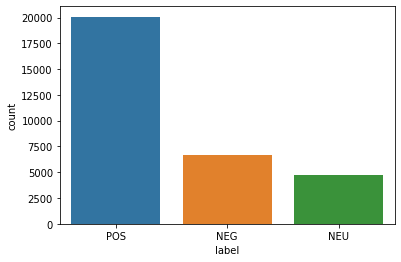

In [ ]:
# vẽ biểu đồ thể hiện số liệu giữa 3 nhãn
sns.countplot(senti_data['label'])

In [ ]:
senti_data.describe()

,Binhluan,label
count,31436,31436
unique,26516,3
top,Chất lượng sản phẩm tuyệt vời,POS
freq,590,20078


In [ ]:
# Xác định độ dài của từ
lengths = senti_data["Binhluan"].str.split().str.len() #tách thành từng mảng r đếm từ
lengths.describe()

count    31436.000000
mean        10.195699
std          8.620445
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max         74.000000
Name: Binhluan, dtype: float64

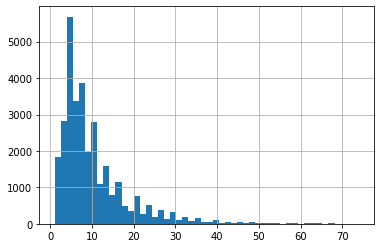

In [ ]:
lengths.hist(bins=50) # len 8 xuất hiện nhìu nhất

# **Tiền xử lý dữ liệu**

In [ ]:
binhluan = senti_data['Binhluan'].values
label = senti_data['label'].values
dict_label = {'NEG': 0, 'NEU': 1, 'POS': 2}

In [ ]:
def pre_process():
  list_content = []
  list_label = []
  # hàm enumerate: thêm vào một bộ đếm(counter) vào trước mỗi iterable
  for i,data in enumerate(binhluan):
    pre_noidung = list(tf.keras.preprocessing.text.text_to_word_sequence(data))
    pre_noidung = " ".join(pre_noidung)
    
    #xu ly co dau 
    pre_noidung_codau = ViTokenizer.tokenize(pre_noidung)
    
    #them vao danh sach
    list_content.append(pre_noidung_codau)
    list_label.append(label[i]) # gán đúng vị trí tương ứng của nhãn đối với bình luận đó

  return list_content,list_label #list_content: conten nối 2 từ _ , list_label: POS, NEG, NEU
  
(list_content,list_label) = pre_process()

In [ ]:
label_pos = [dict_label[i] for i in list_label]
label_tf = tf.keras.utils.to_categorical(label_pos, num_classes = 3, dtype='float32')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(list_content, label_tf, test_size = .15, random_state = 42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size = .2, random_state = 42)


In [ ]:
print("Train:", len(X_train))
print("Test:", len(X_test))
print("Valid:", len(X_valid))

Train: 21376
Test: 4716
Valid: 5344


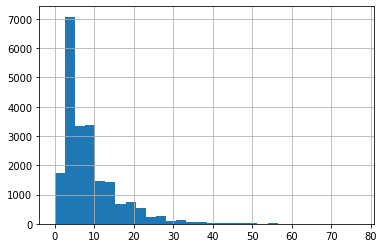

In [ ]:
seq_len = [len(i.split()) for i in X_train]
pd.Series(seq_len).hist(bins = 30)

In [ ]:
tokenizer = Tokenizer(oov_token='<OOV>', filters='', split = ' ') # tạo đối tượng để tách thành các token với oov (loại các từ không có trong huấn luyện)
tokenizer.fit_on_texts(X_train) # học và hiểu các text có trong bộ train -> biến đóng text thành các vocab

# texts_to_sequences Chuyển từng văn bản trong văn bản thành một chuỗi các số nguyên
X_train = tokenizer.texts_to_sequences(X_train) # biến 1 bộ dữ liệu train thành 1 vector với n phần tử
vector_train = pad_sequences(X_train, padding='post', maxlen= 5) #cắt những phần tử có len lớn hơn 5 và ép nó về len = 5, post là cắt ở sau

X_valid = tokenizer.texts_to_sequences(X_valid)
vector_valid = pad_sequences(X_valid, padding='post', maxlen= 5) #tương tự

X_test = tokenizer.texts_to_sequences(X_test)
vector_test = pad_sequences(X_test, padding='post', maxlen= 5) #tương tự

data_vocab_size = len(tokenizer.word_index) + 1 # + 1 vì có thêm oov trong vocab
pickle.dump(tokenizer,open("tokenizer.pkl","wb")) #lưu lại để tái sử dụng

In [ ]:
print("Train vector:", vector_train.shape)
print("Test vector:", vector_valid.shape)
print("Valid vector:", vector_test.shape)
print("Vocab size:", data_vocab_size)

Train vector: (21376, 5)
Test vector: (5344, 5)
Valid vector: (4716, 5)
Vocab size: 6575


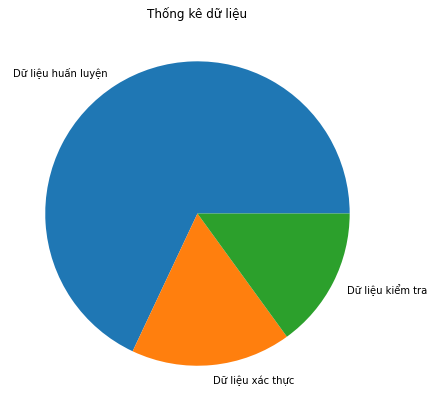

In [ ]:
# Vẽ biểu đồ thống kê dữ liệu 3 bộ train, valid, test
name_labels = ['Dữ liệu huấn luyện', 'Dữ liệu xác thực', 'Dữ liệu kiểm tra']
data = [len(X_train), len(X_valid), len(X_test)]

fig = plt.figure(figsize =(10, 7))
plt.pie(data, labels = name_labels)
plt.title("Thống kê dữ liệu")
# show plot
plt.show()

# **CNN-BiLSTM model**

In [ ]:
def cnn_bi_lstm_model():
  DROPOUT = 0.3
  ACTIVATION = "relu"
  input_dim = data_vocab_size # đầu và là tổng vocab
  output_dim = 32 # số chiều đầu ra
  input_length = 5 # độ dài của 1 từ

  input_layer = Input(shape=(input_length))

  # input_dim: số lượng vocab, out_dim: 1 từ muốn có bao nhiêu chiều -> embedding: chuyển mỗi từ thành n chiều có kích thước cố định
  feature = Embedding(input_dim=input_dim, output_dim = output_dim, input_length = input_length)(input_layer)
  
  # Tổng hợp feature theo 2 hướng, cnn và bilstm
  #CNN
  cnn_feat = Conv1D(filters = 32, kernel_size = 3, padding= 'same', activation = ACTIVATION)(feature) # tạo ra 32 đầu ra
  cnn_feat = MaxPooling1D()(cnn_feat) #giảm số từ xuống
  cnn_feat = Dropout(DROPOUT)(cnn_feat) # tra'nh overfit
  cnn_feat = Conv1D(filters = 32, kernel_size = 3, padding= 'same', activation = ACTIVATION)(cnn_feat)
  cnn_feat = MaxPooling1D()(cnn_feat)
  cnn_feat = LayerNormalization()(cnn_feat)
  cnn_feat = Dropout(DROPOUT)(cnn_feat) # tra'nh overfit

  #bidirection_LSTM: de 'concat' dc thi phai dong bo unit cnn vs bi_lstm

  # Đi 2 chiều từ trái-phải, phải-trái
  bi_lstm_feat = Bidirectional(LSTM(units= 32, dropout = DROPOUT, 
                                    return_sequences = True), merge_mode = 'concat')(feature)#units = 32 la muon ra output 32 chieu #right-left
  bi_lstm_feat = MaxPooling1D()(bi_lstm_feat) #giảm số từ xuống

  bi_lstm_feat = Bidirectional(LSTM(units= 32, dropout = DROPOUT, 
                                   return_sequences = True), merge_mode = 'concat')(bi_lstm_feat) # left-right
  bi_lstm_feat = MaxPooling1D()(bi_lstm_feat)
  bi_lstm_feat = LayerNormalization()(bi_lstm_feat) #chuẩn hóa đầu vào

  combine_feat = tf.keras.layers.Concatenate()([cnn_feat, bi_lstm_feat]) #tổng hợp thành 1 layer chung, duy nhất
  combine_feat = GlobalMaxPooling1D()(combine_feat) #tổng hợp lại
  combine_feat = LayerNormalization()(combine_feat)

  # Phân lớp
  layers = Dense(500, activation = ACTIVATION)(combine_feat)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(200, activation = ACTIVATION)(layers)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(100, activation = ACTIVATION)(layers)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(50, activation = ACTIVATION)(layers)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(3, activation = 'softmax')(combine_feat) # bài toán cho 3 nhãn nên phải dùng softmax

  return tf.keras.Model(inputs = input_layer, outputs = layers) # tra ve model


In [ ]:
# Hiển thị kiến trúc mạng
model_cnn_bi_lstm = cnn_bi_lstm_model()
model_cnn_bi_lstm.compile(optimizer=Adam(0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
model_cnn_bi_lstm.summary() #(None, 5, 32) (None: là không có bactch_size, 5: là số từ, 32: số chiều)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 5, 32)        210400      ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 5, 32)        3104        ['embedding[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 2, 32)        0           ['conv1d[0][0]']                 
                                                                                              

**LƯU MODEL VÀ ĐÀO TÀO**

In [ ]:
EPOCHS = 25
BATCHSIZE = 128

In [ ]:
callback_model_cnn_bi_lstm = tf.keras.callbacks.ModelCheckpoint("model_cnn_bi_lstm.h5",monitor="val_loss") #gọi lại model
# Huấn luyện model
model_cnn_bi_lstm.fit(vector_train, y_train, epochs=EPOCHS, 
          batch_size=BATCHSIZE, validation_data=(vector_valid, y_valid), 
          callbacks=[callback_model_cnn_bi_lstm])#phải là vector_train vs vector_valid

Epoch 1/25
167/167 [==============================] - 34s 58ms/step - loss: 0.7795 - accuracy: 0.6779 - val_loss: 0.6260 - val_accuracy: 0.7388
Epoch 2/25
167/167 [==============================] - 4s 22ms/step - loss: 0.5802 - accuracy: 0.7660 - val_loss: 0.6020 - val_accuracy: 0.7455
Epoch 3/25
167/167 [==============================] - 4s 22ms/step - loss: 0.5175 - accuracy: 0.7952 - val_loss: 0.6311 - val_accuracy: 0.7545
Epoch 4/25
167/167 [==============================] - 4s 21ms/step - loss: 0.4775 - accuracy: 0.8144 - val_loss: 0.6308 - val_accuracy: 0.7522
Epoch 5/25
167/167 [==============================] - 4s 22ms/step - loss: 0.4441 - accuracy: 0.8280 - val_loss: 0.6439 - val_accuracy: 0.7468
Epoch 6/25
167/167 [==============================] - 4s 21ms/step - loss: 0.4169 - accuracy: 0.8409 - val_loss: 0.6881 - val_accuracy: 0.7496
Epoch 7/25
167/167 [==============================] - 4s 21ms/step - loss: 0.3835 - accuracy: 0.8528 - val_loss: 0.7109 - val_accuracy: 0.745

In [ ]:
# model_cnn_bi_lstm = load_model('model_cnn_bi_lstm.h5') 
model_cnn_bi_lstm.load_weights("model_cnn_bi_lstm.h5")
# model_cnn_bi_lstm.evaluate(vector_test, y_test)
acc = model_cnn_bi_lstm.evaluate(vector_test, y_test)[1]
print('Test accuracy:', acc)

148/148 [==============================] - 1s 4ms/step - loss: 1.1050 - accuracy: 0.7349
Test accuracy: 0.7349448800086975


In [ ]:
predicts = model_cnn_bi_lstm.predict(vector_test)
predicts = tf.round(predicts).numpy()

print(classification_report(y_test, predicts, target_names = ['NEG', 'NEU' ,'POS'], zero_division = 0))


              precision    recall  f1-score   support

         NEG       0.63      0.62      0.63      1008
         NEU       0.36      0.23      0.29       737
         POS       0.83      0.89      0.86      2971

   micro avg       0.74      0.73      0.74      4716
   macro avg       0.61      0.58      0.59      4716
weighted avg       0.72      0.73      0.72      4716
 samples avg       0.73      0.73      0.73      4716



# **DỰ ĐOÁN KẾT QUẢ VỚI MÔ HÌNH CNN-BiLSTM**

In [ ]:
def predict_result(text, model, tokenizer):
  # tiền xử lý dữ liệu đầu vào
  pre_noidung = list(tf.keras.preprocessing.text.text_to_word_sequence(text))
  pre_noidung = " ".join(pre_noidung)
  pre_noidung_codau = ViTokenizer.tokenize(pre_noidung)
  print("Văn bản đã xử lý xong:", pre_noidung_codau)
  
  tokenizer_noidung = tokenizer.texts_to_sequences([pre_noidung_codau])
  vector_data = pad_sequences(tokenizer_noidung, padding='post', maxlen = 5)
  # mô hình phân tích suy luận
  res = model(vector_data).numpy()[0]
  # print(res) # trong 1 mảng, vị trí nào có giá trị lớn nhất thì argmax nó ra
  # print(res.argmax()) # trả về vị trí có giá trị lớn nhất
  dotincay = float(res.max()) #lấy giá trị lớn nhất
  dict_label = {'NEG': 0, 'NEU': 1, 'POS': 2}
  brand = list(dict_label.keys()) #lấy tên
  
  # chuyển đổi ký hiệu thành chữ
  label = brand[int(res.argmax())]
  opinion = '' # tạo ý kiến rỗng
  if label == 'NEG': 
    opinion = 'Tiêu cực'
  elif label == 'POS': 
    opinion = 'Tích cực'
  else:
    opinion = 'Trung tính'  

  return opinion, dotincay #trả về vị trí nhãn có giá trị lớn nhất và độ tin cậy

In [ ]:
model1 = load_model('model_cnn_bi_lstm.h5') 

#load tập dữ liệu đã train sẵn
with open(r"tokenizer.pkl","rb") as f:
  tokenizer1 = pickle.load(f)

In [ ]:
print(predict_result('Áo đẹp lắm', model1, tokenizer1)[0])
print(predict_result('Áo xấu quá', model1, tokenizer1)[0])
print(predict_result('Áo trông cũng bình thường', model1, tokenizer1)[0])

Văn bản đã xử lý xong: áo đẹp lắm
Tích cực
Văn bản đã xử lý xong: áo xấu quá
Tiêu cực
Văn bản đã xử lý xong: áo trông cũng bình_thường
Tiêu cực


In [ ]:
print(predict_result('Áo tuy hơi nhiều chỉ, nhưng nhìn chung là đẹp', model1, tokenizer1)[0])
print(predict_result('Hồi sáng mình có đặt 3 cái áo bên shop mà nhăn nheo hết trơn, bực thật sự', model1, tokenizer1)[0])
print(predict_result('Hôm nay mình rất buồn nhưng từ khi nhận được áo này mình đã rất vui vì áo đẹp lắm', model1, tokenizer1)[0])

Văn bản đã xử lý xong: áo tuy hơi nhiều chỉ nhưng nhìn_chung là đẹp
Trung tính
Văn bản đã xử lý xong: hồi sáng mình có đặt 3 cái áo bên shop mà nhăn_nheo hết trơn bực thật_sự
Tiêu cực
Văn bản đã xử lý xong: hôm_nay mình rất buồn nhưng từ khi nhận được áo này mình đã rất vui vì áo đẹp lắm
Tích cực


In [ ]:
# while(True):
#   print("Nhập 1 bình luận bất kỳ:")
#   text = input()
#   if text == "exit()":
#     break
#   else:
#     predict,score = predict_result(text, model2, tokenizer2)
#     print("Xin dự đoán bình luận trên là:", predict)
#     # print("Với độ tin cậy đến: {:.2f}%".format(score * 100))
#     print()

# **CNN model**

In [ ]:
def cnn_model():
  DROPOUT = 0.3
  ACTIVATION = "relu"
  input_dim = data_vocab_size
  output_dim = 32 #số chiều 
  input_length = 5

  input_layer = Input(shape=(input_length))
  feature = Embedding(input_dim=input_dim, output_dim = output_dim, input_length = input_length)(input_layer)

  #CNN
  cnn_feat = Conv1D(filters = 32, kernel_size = 3, padding= 'same', activation = ACTIVATION)(feature)
  cnn_feat = MaxPooling1D()(cnn_feat) 
  cnn_feat = Conv1D(filters = 32, kernel_size = 3, padding= 'same', activation = ACTIVATION)(cnn_feat)
  cnn_feat = MaxPooling1D()(cnn_feat) 
  cnn_feat = Dropout(DROPOUT)(cnn_feat) # tra'nh overfit
  cnn_feat = GlobalMaxPooling1D()(cnn_feat) # PHẢI CÓ
  cnn_feat = Flatten()(cnn_feat) # làm phẳng các lớp trước khi dense
  
  # Phân lớp
  layers = Dense(500, activation = ACTIVATION)(cnn_feat)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(200, activation = ACTIVATION)(layers)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(100, activation = ACTIVATION)(layers)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(50, activation = ACTIVATION)(layers)
  layers = Dropout(DROPOUT)(layers)
  layers = Dense(3, activation = 'softmax')(layers)

  return tf.keras.Model(inputs = input_layer, outputs = layers) # tra ve model

model_CNN = cnn_model()
model_CNN.compile(optimizer=Adam(0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])
model_CNN.summary() 

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5)]               0         
                                                                 
 embedding_1 (Embedding)     (None, 5, 32)             210400    
                                                                 
 conv1d_2 (Conv1D)           (None, 5, 32)             3104      
                                                                 
 max_pooling1d_4 (MaxPooling  (None, 2, 32)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 2, 32)             3104      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, 1, 32)            0         
 1D)                                                       

In [ ]:
EPOCHS = 25
BATCHSIZE = 128

In [ ]:
callback_model_cnn = tf.keras.callbacks.ModelCheckpoint("model_cnn.h5",monitor="val_loss")
model_CNN.fit(vector_train, y_train, epochs=EPOCHS, 
          batch_size=BATCHSIZE, validation_data=(vector_valid, y_valid), 
          callbacks=[callback_model_cnn])#phải là vector_train vs vector_valid

Epoch 1/25
167/167 [==============================] - 3s 15ms/step - loss: 0.7476 - accuracy: 0.6636 - val_loss: 0.6377 - val_accuracy: 0.7431
Epoch 2/25
167/167 [==============================] - 2s 13ms/step - loss: 0.5878 - accuracy: 0.7671 - val_loss: 0.5900 - val_accuracy: 0.7532
Epoch 3/25
167/167 [==============================] - 2s 14ms/step - loss: 0.5205 - accuracy: 0.7927 - val_loss: 0.6065 - val_accuracy: 0.7560
Epoch 4/25
167/167 [==============================] - 2s 14ms/step - loss: 0.4686 - accuracy: 0.8148 - val_loss: 0.6151 - val_accuracy: 0.7524
Epoch 5/25
167/167 [==============================] - 2s 14ms/step - loss: 0.4116 - accuracy: 0.8372 - val_loss: 0.6726 - val_accuracy: 0.7332
Epoch 6/25
167/167 [==============================] - 2s 14ms/step - loss: 0.3758 - accuracy: 0.8580 - val_loss: 0.7138 - val_accuracy: 0.7391
Epoch 7/25
167/167 [==============================] - 2s 13ms/step - loss: 0.3441 - accuracy: 0.8699 - val_loss: 0.7695 - val_accuracy: 0.7268

In [ ]:
# model_CNN = load_model('model_cnn.h5') 
model_CNN.load_weights("model_cnn.h5")
# model_CNN.evaluate(X_test, y_test)
acc_cnn = model_CNN.evaluate(vector_test, y_test)[1]
print('Test accuracy:', acc_cnn)

148/148 [==============================] - 0s 2ms/step - loss: 1.2654 - accuracy: 0.7299
Test accuracy: 0.7298558354377747


In [ ]:
predicts_cnn = model_CNN.predict(vector_test)
predicts_cnn = tf.round(predicts_cnn).numpy()

print(classification_report(y_test, predicts_cnn, target_names = ['NEG', 'NEU' ,'POS'], zero_division = 0))


              precision    recall  f1-score   support

         NEG       0.65      0.59      0.62      1008
         NEU       0.34      0.31      0.32       737
         POS       0.84      0.88      0.86      2971

   micro avg       0.73      0.73      0.73      4716
   macro avg       0.61      0.59      0.60      4716
weighted avg       0.72      0.73      0.72      4716
 samples avg       0.73      0.73      0.73      4716



# **DỰ ĐOÁN KẾT QUẢ VỚI MÔ HÌNH CNN**

In [ ]:
model2 = load_model('model_cnn.h5') 

#load tập dữ liệu đã train sẵn
with open(r"tokenizer.pkl","rb") as f:
  tokenizer2 = pickle.load(f)

In [ ]:
print(predict_result('Áo đẹp lắm', model2, tokenizer2)[0])
print(predict_result('Áo xấu quá', model2, tokenizer2)[0])
print(predict_result('Áo trông cũng bình thường', model2, tokenizer2)[0])

Văn bản đã xử lý xong: áo đẹp lắm
Tích cực
Văn bản đã xử lý xong: áo xấu quá
Tiêu cực
Văn bản đã xử lý xong: áo trông cũng bình_thường
Trung tính


In [ ]:
print(predict_result('Áo tuy hơi nhiều chỉ, nhưng nhìn chung là đẹp', model2, tokenizer2)[0])
print(predict_result('Hồi sáng mình có đặt 3 cái áo bên shop mà nhăn nheo hết trơn, bực thật sự', model2, tokenizer2)[0])
print(predict_result('Hôm nay mình rất buồn nhưng từ khi nhận được áo này mình đã rất vui vì áo đẹp lắm', model1, tokenizer1)[0])

Văn bản đã xử lý xong: áo tuy hơi nhiều chỉ nhưng nhìn_chung là đẹp
Tích cực
Văn bản đã xử lý xong: hồi sáng mình có đặt 3 cái áo bên shop mà nhăn_nheo hết trơn bực thật_sự
Tiêu cực
Văn bản đã xử lý xong: hôm_nay mình rất buồn nhưng từ khi nhận được áo này mình đã rất vui vì áo đẹp lắm
Tích cực


# **SO SÁNH 2 MÔ HÌNH**

Accuracy CNN+BiLSTM: 73.49 %
Accuracy CNN: 72.99 %



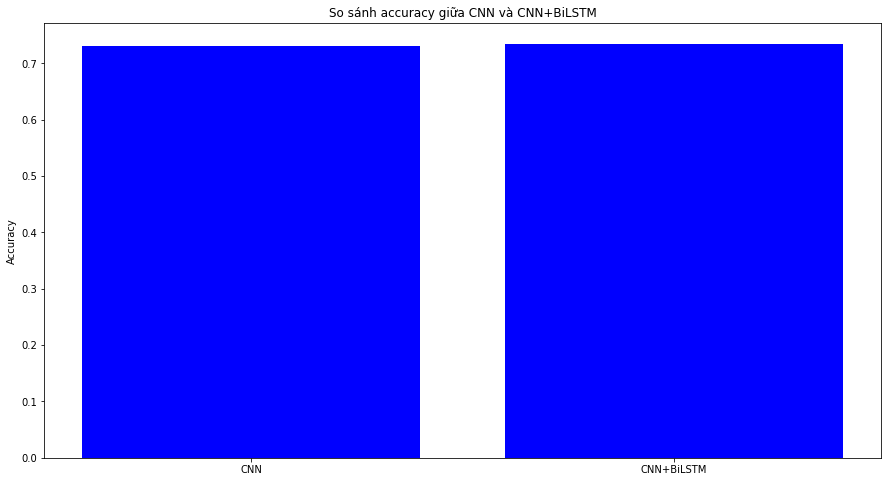

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#hiển thị accuracy
print("Accuracy CNN+BiLSTM: %.2f"%(acc*100),'%')
print("Accuracy CNN: %.2f"%(acc_cnn*100),'%')
print()

# Tạo dataset
data = {'CNN':acc_cnn, 'CNN+BiLSTM':acc}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (15, 8))
 
# Tạo bar plot
plt.bar(courses, values, color ='blue',
        width = 0.8)
 
# plt.xlabel("")
plt.ylabel("Accuracy")
plt.title("So sánh accuracy giữa CNN và CNN+BiLSTM")
plt.show()

f1_score CNN+BiLSTM: 72.19 %
f1_score CNN: 72.55 %



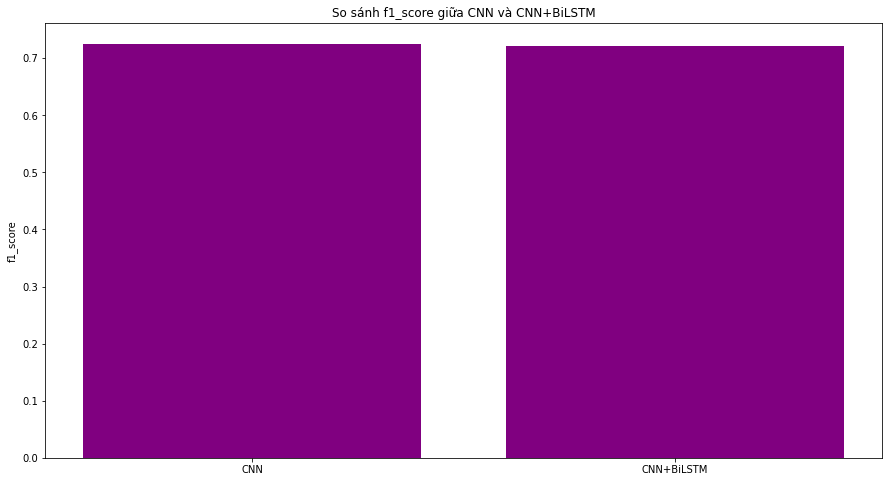

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Tính score
predict_test = model_cnn_bi_lstm.predict(vector_test)
predict_test = predict_test.argmax(-1)
y_test_true = y_test.argmax(-1)
score_cnn_bi_lstm = f1_score(y_test_true, predict_test, average='weighted')
print("f1_score CNN+BiLSTM: %.2f"%(score_cnn_bi_lstm*100),'%')

predict_test2 = model_CNN.predict(vector_test)
predict_test2 = predict_test2.argmax(-1)
y_test_true2 = y_test.argmax(-1)
score_cnn = f1_score(y_test_true2, predict_test2, average='weighted')
print("f1_score CNN: %.2f"%(score_cnn*100),'%')
print()

# Tạo dataset
data = {'CNN':score_cnn, 'CNN+BiLSTM':score_cnn_bi_lstm}
courses = list(data.keys())
values = list(data.values())
  
fig = plt.figure(figsize = (15, 8))

# Tạo bar plot
plt.bar(courses, values, color ='purple',
        width = 0.8)

 
# plt.xlabel("")
plt.ylabel("f1_score")
plt.title("So sánh f1_score giữa CNN và CNN+BiLSTM")
plt.show()